In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_feynmannd
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import dataset_miscnd
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 150 #50
TRAIN_SIZE  = 1.0/3.0 #0.7
NOISE       = 0.05
MESH_SIZE   = 100
TEST_MESH_SIZE   = 200

POPSIZE          = 500
MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 20
GENERATIONS      = 20 #20
GROUP_SIZE       = 3  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3 #5
LIB_MAXLENGTH = 10 #15

BACKPROP_TRIALS = 4

RANDSTATE = 1245

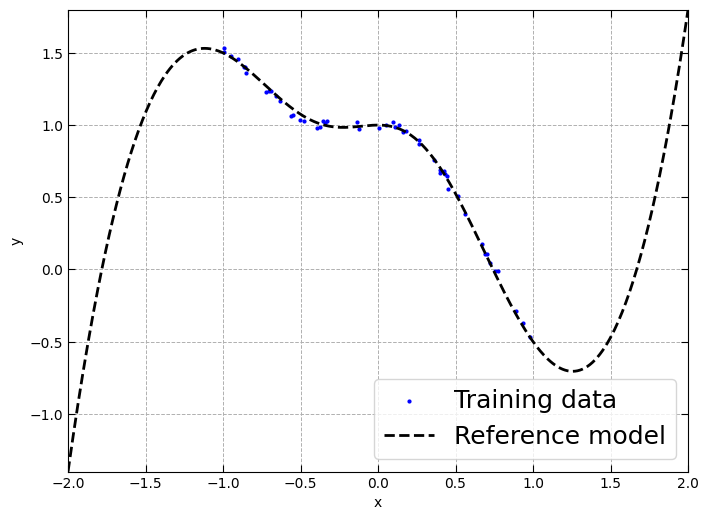

50
100


In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDataset()
#S = dataset_misc1d.Nguyen7()
#S = dataset_misc1d.R1()
S = dataset_misc1d.R2()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc3d.Resistance3()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.RocketFuelFlow()
#S = dataset_physics.AircraftLift()
#S = dataset_misc2d.Pagie1()
#S = dataset_miscnd.WavePower()
#S = dataset_feynmannd.FeynmanIICh6Eq15a()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

print(S_train.y.size)
print(S_test.y.size)

In [4]:
import profiling
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

const_prob = 0.0 if S.knowledge.has_symmvars() else 0.5
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=const_prob)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      gp_mutator.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
data_evaluator = gp_evaluator.NMSEEvaluator(S_train, linscaler=None)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, data_evaluator, know_pressure=0.0)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)
corrector.backprop_trials = BACKPROP_TRIALS

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
symb_regressor = gp.GP(settings)
#symb_regressor = gp.MOGP(settings)
profiling.enable()
with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)
profiling.disable()
profiling.print_stats()

  0%|          | 0/19 [00:00<?, ?it/s]

         12366985 function calls (10605118 primitive calls) in 24.774 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   24.774   12.387 interactiveshell.py:3472(run_code)
        1    0.001    0.001   24.757   24.757 gp.py:128(evolve)
       19    0.188    0.010   24.002    1.263 gp.py:171(_create_children)
     9500    0.528    0.000   15.715    0.002 corrector.py:61(correct)
    16733    0.410    0.000    6.286    0.000 corrector.py:159(backprop_know)
    19881    0.246    0.000    4.354    0.000 library.py:241(query)
    29153    0.059    0.000    3.702    0.000 library.py:97(query)
    29153    2.230    0.000    3.643    0.000 _kdtree.py:363(query)
    10000    0.052    0.000    3.349    0.000 evaluator.py:226(evaluate)
     9632    0.123    0.000    3.224    0.000 crossover.py:30(cross)
396533/133227    0.828    0.000    2.777    0.000 binop.py:29(__getitem__)
    10000    1.146    0.000  

In [5]:
test_data_evaluator = gp_evaluator.NMSEEvaluator(S_test)
best_stree.clear_output()
print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
print(f"Test NMSE: {test_data_evaluator.evaluate(best_stree).value}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")


--- Best syntax tree ---
(((log((1.23 / exp(x0))) + exp(cube((x0 + -0.42)))) - (0.09 / square(exp(x0)))) - cube(x0))
fea: 0.79
NMSE: 0.01110390603903358
Max depth: 6
Length: 20
Test NMSE: 0.017607373062949183


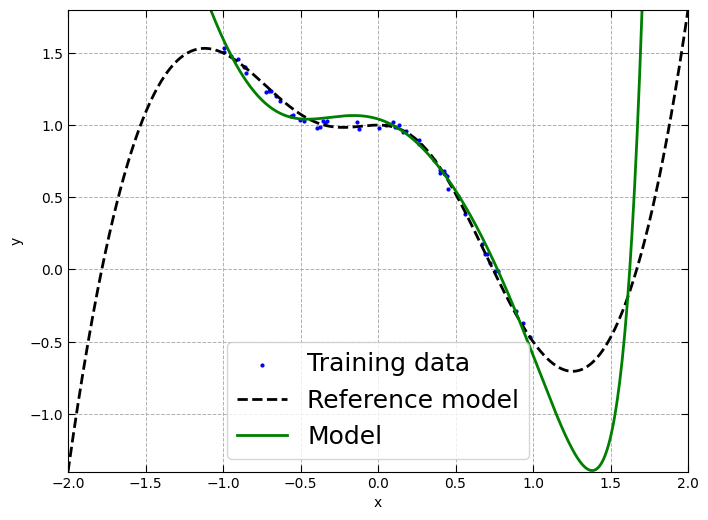

{'mse': 28.03684550426043, 'rmse': 5.294983050422393, 'r2': -46.06759114514935, 'nmse': 47.06759114514935}
(400, 85)


In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
print(S.evaluate_extra(best_stree))

test_mesh           = space.MeshSpace(S_train, S.knowledge, TEST_MESH_SIZE)
test_know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, test_mesh)
print(test_know_evaluator.evaluate(best_stree))

In [7]:
best_stree.clear_output()
scaler = gp_evaluator.LinearScaler(S_train.y)
best_stree_scaled = scaler.scale_stree(best_stree, best_stree(S_train.X))
best_stree_scaled.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree_scaled, zoomout=1)

best_stree_scaled.clear_output()
print(f"Test NMSE: {test_data_evaluator.evaluate(best_stree_scaled).value}")

Test NMSE: 0.017399213181164344


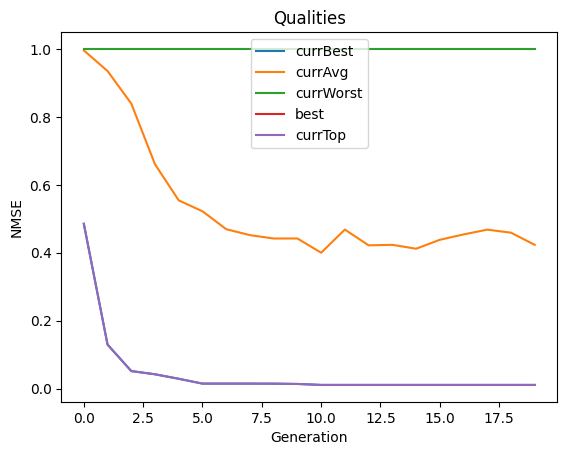

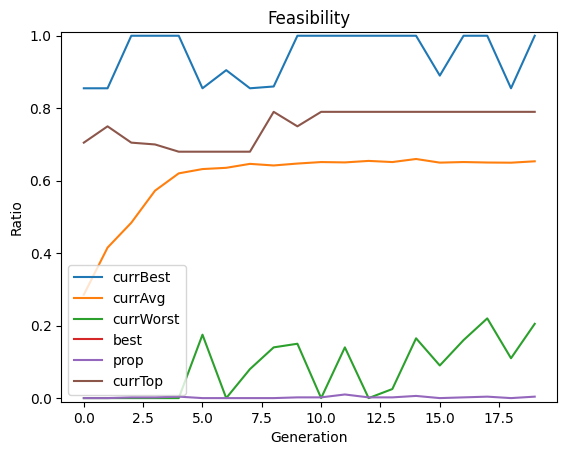

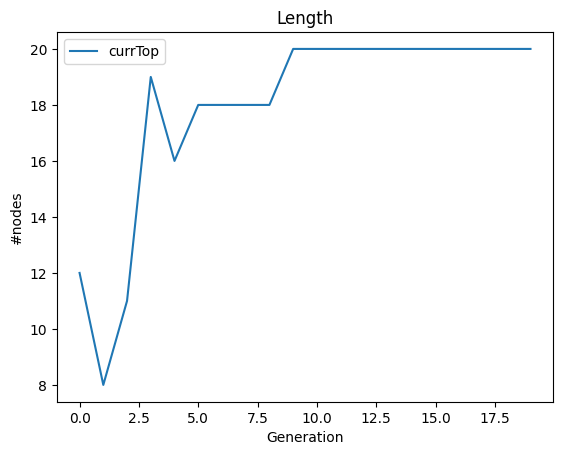

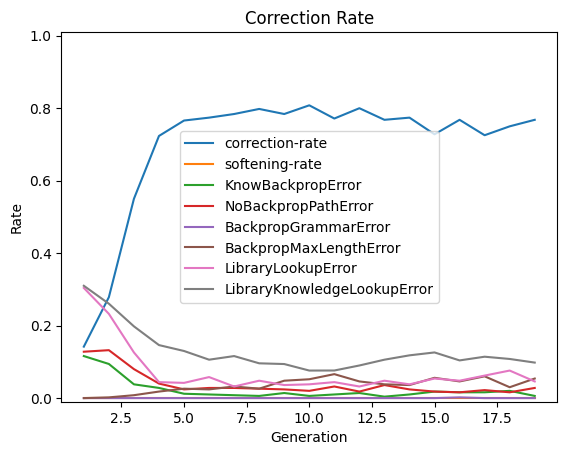

In [8]:
symb_regressor.stats.plot()

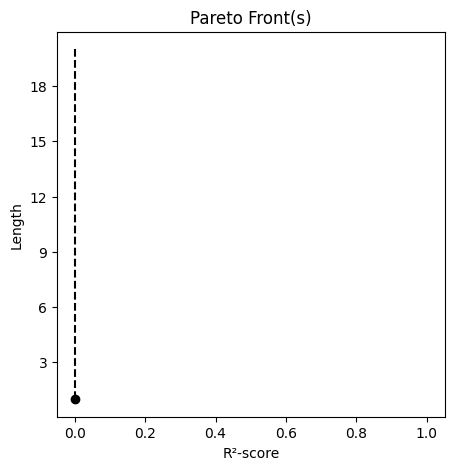

Feasibility Ratio: 1.0
Extent of Convergence: 0.0


,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,0.00,0,0.0,0.0,1,(),1,inf


In [9]:
pd_data = []
front_tracker, fea_ratio = symb_regressor.fea_front_tracker.get_head(0)

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

data_lu = (0.0,1.0)
length_lu = (1,MAX_STREE_LENGTH)

front_tracker.plot(data_lu, length_lu, [0])
print(f"Feasibility Ratio: {fea_ratio}")
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence(data_lu, length_lu)}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)